In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [2]:
class Encoder_block(nn.Module):
  def __init__(self, in_ch, out_ch):
    super(Encoder_block, self).__init__()
    self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=2, padding=1)
    self.bn1 = nn.BatchNorm2d(out_ch)
    self.activ1 = nn.LeakyReLU(0.2)

    self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(out_ch)
    self.activ2 = nn.LeakyReLU(0.2)

    self.res_conv = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=2, padding=1)

  def forward(self, x):
    x_res = self.res_conv(x)

    x = self.activ1(self.bn1(self.conv1(x)))
    x = self.conv2(x) + x_res
    x = self.activ2(self.bn2(x))
    return x

In [3]:
from logging import StreamHandler
class Encoder(nn.Module):
  def __init__(self, in_channels, latent_dim=30):
    super(Encoder, self).__init__()
    self.initial = nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1)
    self.activ = nn.LeakyReLU(0.2)
    self.block1 = Encoder_block(32, 32) # result image 16x16
    self.block2 = Encoder_block(32, 64) # result image 8x8
    self.block3 = Encoder_block(64, 128) # result image 4x4
    self.flatter = nn.Flatten()
    self.mu = nn.Conv2d(128, latent_dim, 4, 1)
    self.log_var = nn.Conv2d(128, latent_dim, 4, 1)

    # self.mu = nn.Linear(128*4*4, latent_dim)
    # self.log_var = nn.Linear(128*4*4, latent_dim)

  def getSample(self, mu, log_var):
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    z = mu + eps * std
    return z

  def forward(self, x):
    x = self.activ(self.initial(x))
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    # x = self.flatter(x)

    mu = self.mu(x)
    log_var = self.log_var(x)
    x_sample = self.getSample(mu, log_var)

    return mu, log_var, x_sample

In [4]:
class Decoder_block(nn.Module):
  def __init__(self, in_ch, out_ch):
    super(Decoder_block, self).__init__()

    self.activ = nn.LeakyReLU(0.2)

    self.bn1 = nn.BatchNorm2d(in_ch)

    self.conv2 = nn.Conv2d(in_ch, in_ch, 3, 1, 1)
    self.bn2 = nn.BatchNorm2d(in_ch)

    self.conv3 = nn.Conv2d(in_ch, out_ch, 3 ,1, 1)

    self.conv_res = nn.Conv2d(in_ch, out_ch, 3, 1, 1)

    self.upsample = nn.Upsample(scale_factor=2)

  def forward(self, x):
    x = self.activ(self.bn1(x))
    x_res = self.upsample(self.conv_res(x))
    x = self.upsample(self.activ(self.bn2(self.conv2(x))))
    x = self.conv3(x)
    x = x + x_res
    return x


In [5]:
class Decoder(nn.Module):
  def __init__(self, in_ch, latent_dim=30):
    super(Decoder, self).__init__()
    self.latent_dim = latent_dim
    self.initial = nn.ConvTranspose2d(latent_dim, 128, kernel_size=4, stride=1)
    self.block1 = Decoder_block(128, 64)
    self.block2 = Decoder_block(64, 32)
    self.block3 = Decoder_block(32, 32)
    self.activ = nn.LeakyReLU(0.2)
    self.final = nn.Conv2d(32, CHANNELS, kernel_size=3, padding=1, stride=1)

  def forward(self, x):
    # x = nn.Linear(self.latent_dim, 128 * 4 * 4)
    # x = lambda x: x.view(-1, 128, 4, 4)
    x = self.initial(x)
    x = self.block1(x)
    x = self.block2(x)
    x = self.activ(self.block3(x))
    x = self.final(x)
    return torch.tanh(x)


In [6]:
class VAE(nn.Module):
  def __init__(self, in_ch=1, latent_dim=30):
    super(VAE, self).__init__()
    self.encoder = Encoder(in_ch, latent_dim)
    self.decoder = Decoder(in_ch, latent_dim)

  def forward(self, x):
    mu, log_var, x_sample = self.encoder(x)
    x_recon = self.decoder(x_sample)
    return x_recon, mu, log_var

In [8]:
def VAE_loss(recon_x, mu, logvar, x, beta=0.1):
  loss_reconstruction = F.mse_loss(recon_x, x)
  loss_KL = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).mean()
  loss = loss_reconstruction + beta * loss_KL
  return loss

In [7]:
! pip install torchinfo

In [12]:
CHANNELS = 3
LR = 0.0001
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LATENT_DIM=128
NUM_EPOCH = 200

transform = transforms.Compose([transforms.Resize(32), transforms.ToTensor(), transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

train_data = datasets.CIFAR10('./', download=True, train=True, transform=transform)
test_data = datasets.CIFAR10('./', download=True, train=False, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
from torchinfo import summary

model = VAE(CHANNELS, LATENT_DIM).to(DEVICE)
summary(model, input_size=(64, CHANNELS, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [64, 3, 32, 32]           --
├─Encoder: 1-1                           [64, 128, 1, 1]           --
│    └─Conv2d: 2-1                       [64, 32, 32, 32]          896
│    └─LeakyReLU: 2-2                    [64, 32, 32, 32]          --
│    └─Encoder_block: 2-3                [64, 32, 16, 16]          --
│    │    └─Conv2d: 3-1                  [64, 32, 16, 16]          9,248
│    │    └─Conv2d: 3-2                  [64, 32, 16, 16]          9,248
│    │    └─BatchNorm2d: 3-3             [64, 32, 16, 16]          64
│    │    └─LeakyReLU: 3-4               [64, 32, 16, 16]          --
│    │    └─Conv2d: 3-5                  [64, 32, 16, 16]          9,248
│    │    └─BatchNorm2d: 3-6             [64, 32, 16, 16]          64
│    │    └─LeakyReLU: 3-7               [64, 32, 16, 16]          --
│    └─Encoder_block: 2-4                [64, 64, 8, 8]            --
│    

In [11]:
import torch.optim as optim
vae = VAE(CHANNELS, LATENT_DIM).to(DEVICE)
opt = optim.Adam(vae.parameters(), lr=LR, betas=(0.5, 0.999))

In [13]:
loss_log = []
train_loss = 0

vae.train()
train_loss = 0
for epoch in range(NUM_EPOCH):
    train_loss = 0
    for data, _ in train_loader:
        image = data.to(DEVICE)
        x_recon, mu, log_var = vae(image)
        loss = VAE_loss(x_recon, mu, log_var, image)
        loss_log.append(loss.item())
        train_loss += loss.item()

        vae.zero_grad()
        loss.backward()
        opt.step()
    if (epoch+1) % 10==0:
      print(f'Epoch: {epoch+1}/{NUM_EPOCH}\t| Training loss: {train_loss:.4f}')

Epoch: 10/200	| Training loss: 66.9579
Epoch: 20/200	| Training loss: 64.9033
Epoch: 30/200	| Training loss: 64.0213
Epoch: 40/200	| Training loss: 63.5069
Epoch: 50/200	| Training loss: 63.1068
Epoch: 60/200	| Training loss: 62.8430
Epoch: 70/200	| Training loss: 62.5672
Epoch: 80/200	| Training loss: 62.3681
Epoch: 90/200	| Training loss: 62.2416
Epoch: 100/200	| Training loss: 62.1015
Epoch: 110/200	| Training loss: 61.9519
Epoch: 120/200	| Training loss: 61.8322
Epoch: 130/200	| Training loss: 61.7057
Epoch: 140/200	| Training loss: 61.6206
Epoch: 150/200	| Training loss: 61.5281
Epoch: 160/200	| Training loss: 61.4629
Epoch: 170/200	| Training loss: 61.3944
Epoch: 180/200	| Training loss: 61.3256
Epoch: 190/200	| Training loss: 61.2171
Epoch: 200/200	| Training loss: 61.1992


GENERATING NEW IMAGES


In [23]:
import torch
from math import log10, sqrt
from skimage.metrics import structural_similarity as ssim
import numpy as np
import torch.nn.functional as F

def PSNR(original, compressed):
    mse = F.mse_loss(original, compressed)
    if mse == 0:
        return 100
    max_pixel = 1.0
    psnr = 20 * log10(max_pixel / sqrt(mse.item()))
    return psnr

def calculate_ssim(original, compressed):
    original = original.cpu().numpy()
    compressed = compressed.cpu().numpy()
    ssim_value = ssim(original, compressed, data_range=1, multichannel=True, win_size=5, channel_axis=0)
    return ssim_value

In [18]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

data_iter = iter(test_loader)

batch = next(data_iter)
images, labels = batch

vae.eval()
recon_data, mu, logvar = vae(images.to(DEVICE))

RECONSTRUCTING IMAGES


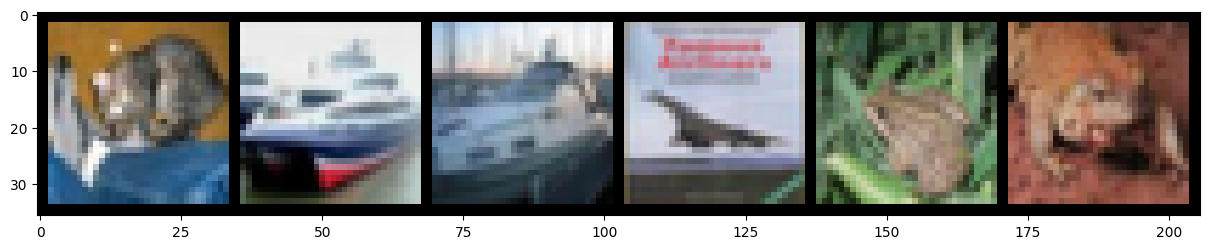

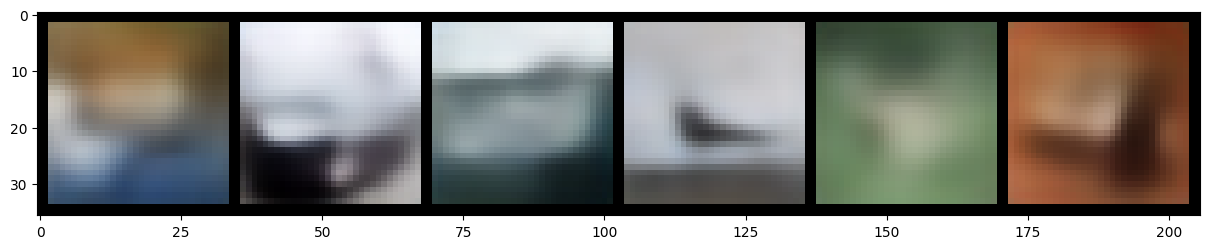

In [19]:
plt.figure(figsize = (15, 10))
out = vutils.make_grid(images[0:6], normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

plt.figure(figsize = (15,10))
out = vutils.make_grid(recon_data.detach().cpu()[0:6], normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

In [25]:
psnr_scores = []
ssim_scores = []

for i in range(len(images[0:6])):
    original = images[i].to('cpu')
    reconstructed = recon_data[i].detach().to('cpu')

    psnr = PSNR(original, reconstructed)
    ssim_value = calculate_ssim(original, reconstructed)

    psnr_scores.append(psnr)
    ssim_scores.append(ssim_value)

print("Average PSNR:", np.mean(psnr_scores))
print("Average SSIM:", np.mean(ssim_scores))

Average PSNR: 13.084432615482172
Average SSIM: 0.24655567


**Висновок**

Можна помітити що згенеровані зображення мають значно менше деталей, і втратили чіткі контури (що і характерно даному типу модель). Загалом якісь зображення знижена, потенційною причиниою може бути або запроста модель, або ж неостатня кількість епох тренування (хоча по тому що лос функція спадає достатньо повільно можна помітити що збільшення кількості епох не допоможе в даному випадку, а навпаки модель може заоверфітитись).
Метрики в свою чергу також сигналізують про те, що модель недостатньо навчена, і метрики достатньо низькі, оскільки PSNR повинна бути принаймні вища > 20, а SSIM в ідеальному випадку рухається до 1 (в даному випадку це 0.25).

Що я буду робити для покращення результатів:
1. Більш складну архітектуру (проте складніша архітектура частковов вже була додана - residual blocks), більше шарів додати, оскільки дана архітектура не справляється з таким датасетом (нижче будуть представлені результати для MNIST - для такого простішого датасету дана модель спрацювала набагато краще).
2. Більше тестів з розмірністю латентного простору (збільшити її).
3. Переглянути баланс у лос функції (можливо баланс між лос реконструкції та лос регуляції порушений).
4. Розширити набір даних для тренування - зробити аугментацію.
5. Додати регулязицію- droupout та early stopping.

Модель не зберігає дрібні деталі зображень, тому результати будуть достатньо розмитими, хоча загальні кольорові блоки, форми будуть збережені.


GENERATING MEW IMAGES


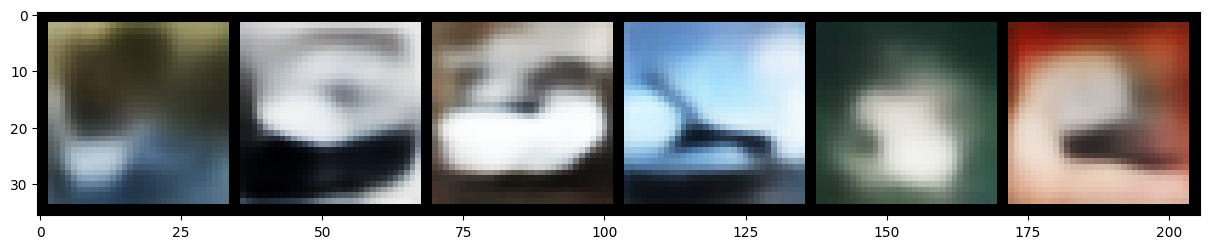

In [27]:
rand_samp = vae.decoder(mu + 1 * torch.randn_like(mu))
plt.figure(figsize = (15, 10))
out = vutils.make_grid(rand_samp.detach().cpu()[0:6], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

Можна помітити що генерація показує певну різноманітність кольорів, форм, тобто всетаки модель почала захоплювати основны риси зображень, тобто глобальні особливості вловляються, проте вони дуже розмиті та недеталізовані.
Можливо знову ж таки малий латентний простір, проста архітектура моделі (хоча residula блоки для покращення моделі вже були використані).

Додатково можливо неправильно заданий параметр бета, що допомагає отримати баланс між різними лос функціями.

**ТЕСТУВАННЯ МОДЕЛІ НА ІНШОМУ ДАТАСЕТІ- MNIST**


In [33]:
CHANNELS = 1
LR = 0.0001
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LATENT_DIM=128
NUM_EPOCH = 100

transform = transforms.Compose([transforms.Resize(32), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

train_data = datasets.MNIST('./', download=True, train=True, transform=transform)
test_data = datasets.MNIST('./', download=True, train=False, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [34]:
import torch.optim as optim
vae = VAE(CHANNELS, LATENT_DIM).to(DEVICE)
opt = optim.Adam(vae.parameters(), lr=LR, betas=(0.5, 0.999))

In [35]:
loss_log = []
train_loss = 0

vae.train()
train_loss = 0
for epoch in range(NUM_EPOCH):
    train_loss = 0
    for data, _ in train_loader:
        image = data.to(DEVICE)
        x_recon, mu, log_var = vae(image)
        loss = VAE_loss(x_recon, mu, log_var, image)
        loss_log.append(loss.item())
        train_loss += loss.item()

        vae.zero_grad()
        loss.backward()
        opt.step()
    if (epoch+1) % 10==0:
      print(f'Epoch: {epoch+1}/{NUM_EPOCH}\t| Training loss: {train_loss:.4f}')

Epoch: 10/100	| Training loss: 44.8737
Epoch: 20/100	| Training loss: 41.8726
Epoch: 30/100	| Training loss: 40.3704
Epoch: 40/100	| Training loss: 39.2293
Epoch: 50/100	| Training loss: 38.4294
Epoch: 60/100	| Training loss: 37.8511
Epoch: 70/100	| Training loss: 37.4314
Epoch: 80/100	| Training loss: 37.0051
Epoch: 90/100	| Training loss: 36.7094
Epoch: 100/100	| Training loss: 36.4137


In [44]:
psnr_scores = []
ssim_scores = []

for i in range(len(images[0:6])):
    original = images[i].to('cpu')
    reconstructed = recon_data[i].detach().to('cpu')

    psnr = PSNR(original, reconstructed)
    ssim_value = calculate_ssim(original, reconstructed)

    psnr_scores.append(psnr)
    ssim_scores.append(ssim_value)

print("Average PSNR:", np.mean(psnr_scores))
print("Average SSIM:", np.mean(ssim_scores))

Average PSNR: 19.389599541422772
Average SSIM: 0.89003915


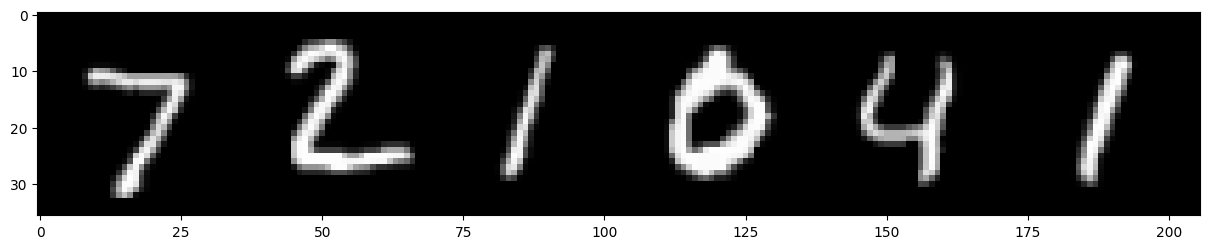

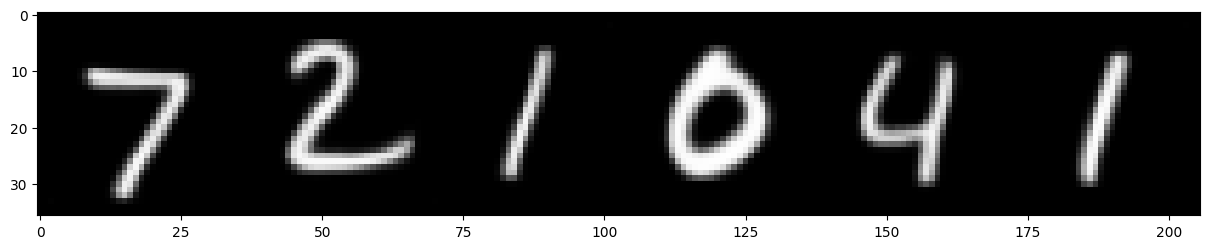

In [37]:
data_iter = iter(test_loader)

batch = next(data_iter)
images, labels = batch

vae.eval()
recon_data, mu, logvar = vae(images.to(DEVICE))
plt.figure(figsize = (15, 10))
out = vutils.make_grid(images[0:6], normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

plt.figure(figsize = (15,10))
out = vutils.make_grid(recon_data.detach().cpu()[0:6], normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

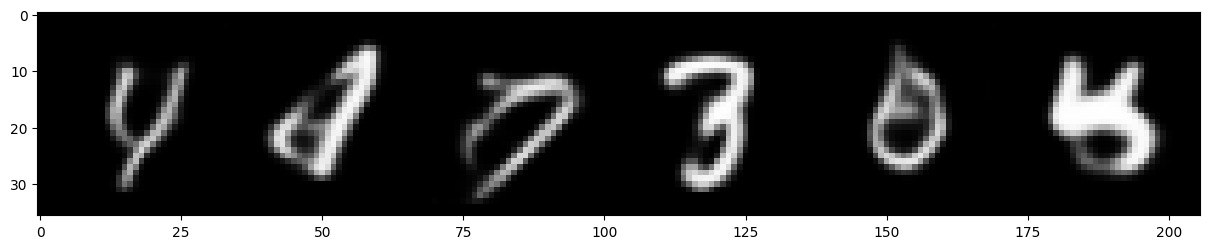

In [43]:
sample = torch.randn(64, LATENT_DIM).to(DEVICE)
sample = vae.decoder(sample.view(64, LATENT_DIM, 1, 1)).cpu()
plt.figure(figsize=(15, 10))
out = vutils.make_grid(sample.detach().cpu()[0:6], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))


ВИСНОВКИ:
Можна помітити що дана модель набагато краще працює на MNIST датасеті, як для генерації нових зображень так і для відновлення зображень. Звідси можна зробити висновки що для складнішого датасету - а саме CIFAR10 потрібно дійнсно погратись більше  латентним простором а також з ахрітектурою.